<h1> Master </h1>

<h3> Imports</h3>

In [1]:
import pandas as pd
import sklearn as sk
import causallearn as cl
from causallearn.utils.cit import fisherz
from causallearn.search.ConstraintBased.PC import pc
from causallearn.search.ScoreBased.GES import ges
#from causallearn.search.Granger.Granger import 
from causallearn.utils.GraphUtils import GraphUtils
import matplotlib.pyplot as plt
from IPython.display import Image
from causal_discovery.algos.notears import NoTears
import numpy as np
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F
import dagma
from dagma.nonlinear import DagmaMLP, DagmaNonlinear
import dagma.utils as du
import torch.optim as optim


In [2]:
np.random.seed(42)

In [3]:
df = pd.read_excel("../Data/batt201900135-sup-0001-full_dataset_mass_loading_1.xlsx")
labels = [df.columns]
# Convert to numpy array
data = df.to_numpy()
print(data.shape)
print(labels)
n_samples = data.shape[0]
n_features = data.shape[1]

(656, 6)
[Index(['Composition (A.M.%)', 'S-to-L Ratio (%)', 'Comma gap (µm)',
       'Viscosity (Pas)', 'Mass Loading (mg cm-2) ', 'Porosity (%)'],
      dtype='object')]


<h3> PC-algorithm <h3>

In [4]:
# Run PC algorithm
pc_alg = pc(data, alpha=0.05, ci_test=fisherz)

# Visualize causal graph
pydot_graph_pc = GraphUtils.to_pydot(pc_alg.G, labels=labels[0])
pydot_graph_pc.write_png('pc_graph.png')

  0%|          | 0/6 [00:00<?, ?it/s]

In [5]:
ges_alg = ges(data)
pydot_graph_ges = GraphUtils.to_pydot(ges_alg['G'], labels=labels[0]) # numpy array
pydot_graph_ges.write_png('ges_graph.png')

In [6]:
#No tears

no_tears_alg = NoTears(rho=1, alpha=0.1, l1_reg=0, lr=1e-2)

no_tears_alg.learn(data)

W_est = no_tears_alg.get_result()

100%|██████████| 20/20 [00:01<00:00, 12.13it/s]


In [7]:
threshold = 0.3
dag = (np.abs(W_est) > threshold).astype(int)
print("Binary DAG adjacency matrix:\n", dag)

Binary DAG adjacency matrix:
 [[0 0 1 0 0 0]
 [1 0 1 0 0 0]
 [0 0 0 0 0 0]
 [0 1 1 0 1 1]
 [0 1 1 0 0 0]
 [1 1 1 0 0 0]]


In [8]:
G = nx.DiGraph()

for i in range(6):
    G.add_node(labels[0][i])

# Add edges
for i in range(n_features):
    for j in range(n_features):
        if dag[i, j] == 1:
            G.add_edge(labels[0][i], labels[0][j], weight=W_est[i, j])

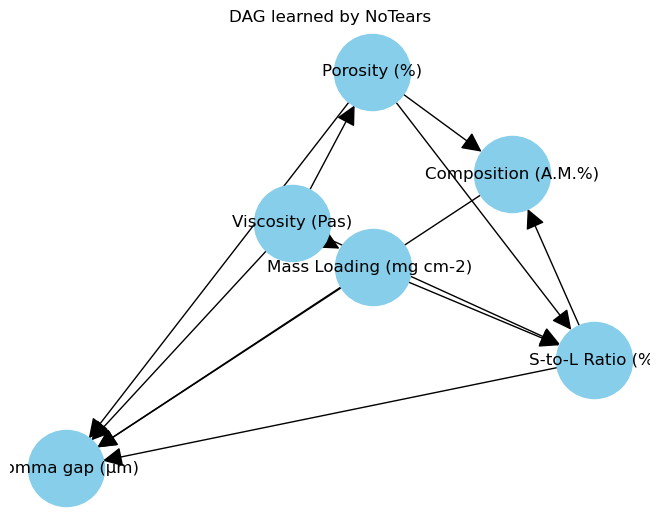

In [9]:
pos = nx.spring_layout(G, seed=42)
#edge_labels = {(i, j): f"{G[i][j]['weight']:.2f}" for i, j in G.edges()}
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='skyblue', arrowsize=30)
#nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title("DAG learned by NoTears")
plt.show()

In [10]:
model = DagmaMLP(dims=[6,10, 6,1])
tensor_data = torch.tensor(data)
optimizer = optim.Adam(model.parameters(), lr=5e-4)

lambda1 = 0.0001   # sparsity regularization
rho = 0.1        # penalty strength for acyclicity
alpha = 0.001      # Lagrange multiplier
epoch = 30000
for i in range(epoch):
    optimizer.zero_grad()
    x = model(tensor_data)
    h = model.h_func()
    l1 = model.fc1_l1_reg()
    mse = torch.mean((tensor_data - x) ** 2)

    # Combined DAGMA loss
    loss = mse + lambda1 * l1 + 0.5 * rho * h * h + alpha * h
    loss.backward()
    optimizer.step()

    # Update alpha occasionally (like in augmented Lagrangian)
    if i % 100 == 0:
        alpha += rho * h.item()

    if i % 1000 == 0:
        print(f"Epoch {i} | Loss: {loss.item():.5f} | h(W): {h.item():.6f}")


W_est = model.fc1_to_adj()
threshold = 0.3
W_bin = (np.abs(W_est) > threshold).astype(int)
print("Learned adjacency matrix:\n", W_bin)


Epoch 0 | Loss: 14723.51113 | h(W): 0.000000
Epoch 1000 | Loss: 14192.83799 | h(W): 0.027907
Epoch 2000 | Loss: 13565.28055 | h(W): 0.029578
Epoch 3000 | Loss: 13041.01746 | h(W): 0.037977
Epoch 4000 | Loss: 12564.37031 | h(W): 0.178101
Epoch 5000 | Loss: 12111.78111 | h(W): 0.195261
Epoch 6000 | Loss: 11680.55985 | h(W): 0.155018
Epoch 7000 | Loss: 11268.15569 | h(W): 0.113884
Epoch 8000 | Loss: 10873.09133 | h(W): 0.080020
Epoch 9000 | Loss: 10495.16055 | h(W): 0.059506
Epoch 10000 | Loss: 10133.54309 | h(W): 0.048181
Epoch 11000 | Loss: 9787.85902 | h(W): 0.041372
Epoch 12000 | Loss: 9457.81489 | h(W): 0.039980
Epoch 13000 | Loss: 9142.90891 | h(W): 0.041124
Epoch 14000 | Loss: 8842.56358 | h(W): 0.038350
Epoch 15000 | Loss: 8556.14264 | h(W): 0.036890
Epoch 16000 | Loss: 8282.90826 | h(W): 0.035255
Epoch 17000 | Loss: 8021.89778 | h(W): 0.035263
Epoch 18000 | Loss: 7771.69009 | h(W): 0.045590
Epoch 19000 | Loss: 7532.07058 | h(W): 0.055399
Epoch 20000 | Loss: 7302.46397 | h(W): 0.0

In [18]:
dagma_model = DagmaMLP(dims=[6,10, 6,1])
model_nonlinear = DagmaNonlinear(dagma_model)
tensor_data = torch.tensor(data)

array = model_nonlinear.fit(tensor_data, lambda1 = 0.0005, lambda2=0.0001, lr=5e-4)

print("Learned adjacency matrix:\n", array)

  0%|          | 0/230000.0 [00:00<?, ?it/s]

Learned adjacency matrix:
 [[0.         0.         1.00351268 0.         0.         0.        ]
 [0.         0.         2.75013128 0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]
 [0.         0.         2.20434559 0.         0.         0.33510815]
 [0.         0.         4.26660265 0.         0.         0.        ]
 [0.         0.         1.0586243  0.         0.         0.        ]]
